In [1]:
%pip install -qU pypdf langchain-community langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


##### RAG(Retrieval-Augmented Generation)에서, 전체 문서를 그대로 LLM에 넘기면 토큰 제한을 초과할 가능성이 큽니다.
- 토큰 제한을 초과하면 모델이 입력을 잘라내거나 오류가 발생할 수 있습니다.
- 비록 초과하지 않는다 해도, 불필요하게 긴 문서는 응답 생성 시간과 비용을 늘립니다.

##### 문서를 적절한 단위(“chunk” 혹은 “paragraph”)로 나누는 이유
- 한 번에 모델에 넣을 수 있는 텍스트 분량(맥시멈 토큰 수)을 넘지 않도록 나누어 처리합니다.
- 검색(Retrieval) 시 사용자 질문과 가장 관련성 높은 문단만 골라서 LLM에 전달하므로, 토큰 사용량을 줄이고 답변 품질을 높입니다.

##### Retriever가 Paragraph(또는 Chunk) 단위로 검색
- 문서를 일정 크기로 “청크”로 나눈 뒤, 각 청크를 벡터 스토어 등에 저장합니다(임베딩).
- 질문이 들어오면 관련성이 높은 청크만 골라 LLM에 전달합니다.
- 이것이 “문단 단위로 필요한 만큼만” 모델에 주는 핵심 아이디어입니다.

##### 정리:
- 설명에 언급된 대로, 전체 문서를 통째로 보내면 토큰 초과나 비효율 문제가 생긴다.
- 이를 피하려고 문서를 적절히 나눈 뒤, 질문과 관련된 부분만 LLM에 주는 방식이 RAG에서 일반적으로 쓰이는 방법이다.
- Retriever(검색 단계)에서는 이렇게 나눈 “문단(청크)” 단위를 기반으로 검색·필터링하여 필요한 부분만 추출한다.

In [2]:
from langchain_community.document_loaders import PyPDFLoader

pdf_file_path = '../spring_framework_docs.pdf'
loader = PyPDFLoader(pdf_file_path)
pages = []
# 쪽수별로 문서를 append
async for page in loader.alazy_load():
    pages.append(page)

In [3]:
pages

[Document(metadata={'producer': 'Microsoft® Word 2016', 'creator': 'Microsoft® Word 2016', 'creationdate': '2025-02-09T14:49:24+09:00', 'author': '이수호', 'moddate': '2025-02-09T14:49:24+09:00', 'source': '../spring_framework_docs.pdf', 'total_pages': 6, 'page': 0, 'page_label': '1'}, page_content='스프링 프레임워크 종합 안내서 \n스프링 프레임워크 종합 안내서 \n본 문서는 스프링 프레임워크의 기본 개념, 아키텍처, 주요 기능 및 최신 동향을 \n포함하여 총 10 페이지에 걸쳐 상세하게 설명합니다. \n서론 \n1. 개요 \n스프링 프레임워크는 자바 플랫폼을 위한 오픈 소스 애플리케이션 프레임워크로, \n엔터프라이즈급 애플리케이션 개발을 위한 다양한 기능과 유연한 아키텍처를 \n제공합니다. \n\uf0b7 역사: 2002 년 로드 존슨(Rod Johnson)의 “Expert One-on-One J2EE \nDesign and Development”를 시작으로 등장하였으며, 이후 경량 \n컨테이너와 객체 지향 프로그래밍 기법을 도입하여 급속히 \n확산되었습니다. \n\uf0b7 목적: 복잡한 엔터프라이즈 애플리케이션 개발 시 발생하는 결합도 문제를 \n해소하고, 모듈화 및 재사용성을 높여 개발 생산성을 극대화하는 데 \n있습니다. \n2. 스프링의 필요성 \n\uf0b7 유연성: 전통적인 J2EE 기반의 복잡한 설정과 구현을 단순화합니다. \n\uf0b7 모듈성: IoC/DI, AOP 등 모듈화를 통해 유지보수를 쉽게 합니다. \n\uf0b7 확장성: 다양한 서브 모듈(웹, 데이터 접근, 보안 등)을 제공하여 복합적인 \n요구 사항을 충족합니다. \n참고: Soonggi Tistory \n핵심 원칙 – IoC 와 DI \n1. 제어

In [4]:
# PDF 문서안에 테이블과 이미지와 같은 문서를 추출하기 위해 zerox 패키지를 사용
# https://github.com/getomni-ai/zerox
%pip install py-zerox

Note: you may need to restart the kernel to use updated packages.


In [5]:
# asyncio를 실행할 때, 이벤트루프가 없어야하나, notebook엣 default로 발생시키는 이벤트루프가 있어서, nest_asyncio를 사용하여 중첩된 이벤트루프를 사용할 수 있도록 함
%pip install -q nest_asyncio

Note: you may need to restart the kernel to use updated packages.


In [6]:
import nest_asyncio
nest_asyncio.apply()

In [7]:
# 문서를 AI가 파싱하여 텍스트로 변환하는데 사용하기 떄문에 가격이 매우매우 비싸다. 조심해서 사용해야함

import os
import sys
import json
import asyncio

# 가능하면 최상단에서 호출 (주피터/파이썬 REPL 등 환경에 따라서 순서가 중요할 수 있음)
from dotenv import load_dotenv

try:
    # UTF-8 출력이 가능한 환경(일반 파이썬 실행)에서만 적용
    # 주피터/IPython 환경에서는 OutStream이어서 reconfigure 호출시 AttributeError가 날 수 있음
    sys.stdout.reconfigure(encoding='utf-8')
except AttributeError:
    pass

# .env 파일 로드 (OPENAI_API_KEY 등 환경 변수 확인)
load_dotenv()

# PyZeroX 임포트는 .env 로드 후에 하는 것을 권장
from pyzerox import zerox


def check_environment_variables() -> None:
    """
    주 사용 환경 변수(예: OPENAI_API_KEY)가 제대로 설정되어 있는지 검사.
    미설정 시 조기 종료 또는 사용자에게 경고 표시.
    """
    openai_key = os.getenv("OPENAI_API_KEY")
    if not openai_key or not openai_key.startswith("sk-"):
        raise EnvironmentError(
            "OPENAI_API_KEY가 제대로 설정되어 있지 않거나 'sk-'로 시작하지 않습니다.\n"
            "비싼 API 호출 실패를 방지하기 위해 프로그램을 종료합니다."
        )


async def process_pdf(
    file_path: str,
    model: str = "gpt-4o",
    output_dir: str = "./documents",
    select_pages=None,
    system_prompt=None,
    **kwargs
):
    """
    PDF를 처리해서 결과를 반환하는 메인 비동기 함수.
    
    :param file_path: 분석할 PDF 파일 경로
    :param model: 사용할 모델 (기본값 "gpt-4o-mini")
    :param output_dir: 처리 결과(마크다운 등) 저장 경로
    :param select_pages: 처리할 페이지 선택 (None이면 전체)
    :param system_prompt: 시스템 프롬프트
    :param kwargs: 모델별 추가 파라미터
    :return: Zerox가 생성한 결과
    """
    result = await zerox(
        file_path=file_path,
        model=model,
        output_dir=output_dir,
        custom_system_prompt=system_prompt,
        select_pages=select_pages,
        **kwargs
    )
    return result


def main():
    """
    실제 실행을 담당하는 메인 함수.
    """
    # 1) 환경 변수 점검
    check_environment_variables()

    # 2) 원하는 파라미터 설정
    file_path = "../spring_framework_docs.pdf"
    model_name = "gpt-4o"   # 필요 시 "gpt-4", "gpt-3.5-turbo" 등으로 교체
    output_dir = "./documents"
    select_pages = None  # None이면 모든 페이지 처리
    system_prompt = None # 필요 시 사용자 정의 시스템 프롬프트 지정

    # 3) 비동기 함수 실행
    try:
        result = asyncio.run(process_pdf(
            file_path=file_path,
            model=model_name,
            output_dir=output_dir,
            select_pages=select_pages,
            system_prompt=system_prompt
        ))
    except Exception as e:
        print(f"오류가 발생하여 작업을 중단합니다: {e}")
        return

    # 4) 결과 출력 (너무 길 경우 파일 저장만 하고 간단히 요약만 보여줄 수도 있음)
    print(result)


if __name__ == "__main__":
    main()


/root/.pyenv/versions/3.11.2/lib/python3.11/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)


KeyboardInterrupt: 

In [ ]:
%pip install -q "unstructured[md]" nltk

Note: you may need to restart the kernel to use updated packages.


In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,  # 1500자씩 분할
    chunk_overlap=100,  # 100자씩 중첩
    separators=['\n\n', '\n']
)

In [10]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_core.documents import Document

markdown_path = "./documents/spring_framework_docs.md"
loader = UnstructuredMarkdownLoader(markdown_path)
document_list = loader.load_and_split(text_splitter)

In [11]:
document_list

[Document(metadata={'source': './documents/spring_framework_docs.md'}, page_content='스프링 프레임워크 종합 안내서\n\n본 문서는 스프링 프레임워크의 기본 개념, 아키텍처, 주요 기능 및 최신 동향을 포함하여 총 10 페이지에 걸쳐 상세하게 설명합니다.\n\n서론\n\n1. 개요\n\n스프링 프레임워크는 자바 플랫폼을 위한 오픈 소스 애플리케이션 프레임워크로, 엔터프라이즈급 애플리케이션 개발을 위한 다양한 기능과 유연한 아키텍처를 제공합니다.\n\n역사: 2002년 로드 존슨(Rod Johnson)의 “Expert One-on-One J2EE Design and Development”를 시작으로 등장하였으며, 이후 경량 컨테이너와 객체 지향 프로그래밍 기법을 도입하여 급속히 확산되었습니다.\n\n목적: 복잡한 엔터프라이즈 애플리케이션 개발 시 발생하는 결합도 문제를 해소하고, 모듈화 및 재사용성을 높여 개발 생산성을 극대화하는 데 있습니다.\n\n2. 스프링의 필요성\n\n유연성: 전통적인 J2EE 기반의 복잡한 설정과 구현을 단순화합니다.\n\n모듈성: IoC/DI, AOP 등 모듈화를 통해 유저보수를 쉽게 합니다.\n\n확장성: 다양한 서브 모듈(웹, 데이터베이스 접근, 보안 등)을 제공하여 복합적인 요구 사항을 충족합니다.\n\n참고: Soonggi Tistory\n\n핵심 원칙 – IoC 와 DI\n\n1. 제어의 역전(IoC, Inversion of Control)\n\n개념: 객체의 생성과 의존관계 설정을 개발자가 아닌 스프링 컨테이너가 관리하는 방식입니다.\n\n장점: 결합도를 낮추어 코드의 재사용성과 테스트 용이성을 높입니다.\n\n2. 의존성 주입(DI, Dependency Injection)\n\n정의: 객체가 필요한 의존성을 스프링 컨테이너가 주입해 주는 방식입니다.\n\n구현 방식: XML 설정, 애노테이션(@Autowired), 자바 기반 설정(@Configuration

In [ ]:
%pip install -q markdown html2text beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import markdown
from bs4 import BeautifulSoup

# 마크다운 파일 경로
markdown_path = './documents/spring_framework_docs.md'
# 변환된 텍스트를 저장할 파일 경로
text_path = './documents/spring_framework_docs.txt'

# 마크다운 파일을 읽어옵니다
with open(markdown_path, 'r', encoding='utf-8') as md_file:
    md_content = md_file.read()

# 마크다운 콘텐츠를 HTML로 변환합니다
html_content = markdown.markdown(md_content)

# HTML 콘텐츠를 파싱하여 텍스트만 추출합니다
soup = BeautifulSoup(html_content, 'html.parser')
text_content = soup.get_text()

# 추출한 텍스트를 텍스트 파일로 저장합니다
with open(text_path, 'w', encoding='utf-8') as txt_file:
    txt_file.write(text_content)

print("Markdown converted to plain text successfully!")


Markdown converted to plain text successfully!


In [14]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader(text_path, encoding="utf-8")
document_list = loader.load_and_split(text_splitter)

In [ ]:
%pip install -q langchain-chroma

Note: you may need to restart the kernel to use updated packages.


In [16]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

In [17]:
from langchain_chroma import Chroma

vector_store = Chroma.from_documents(
    documents=document_list,
    embedding=embeddings,
    collection_name='spring_framework_docs',
    persist_directory='./spring_framework_docs'
)

In [18]:
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [19]:
query = "스프링 프레임워크란?"

In [ ]:
# 질문과 가장 유사한 문서 3개를 검색
retriever.invoke(query)

[Document(id='74d4a601-e19c-4c70-b493-2fa406e6a210', metadata={'source': './documents/spring_framework_docs.txt'}, page_content='이벤트: 스프링의 이벤트 발행/구독 모델을 통해 애플리케이션 간의 느슨한 결합을 구현할 수 있습니다.\n\n\n기타 확장 기능\n\n\n캐싱: 스프링은 다양한 캐시 추상화 기능을 제공하여 애플리케이션 성능을 향상시킵니다.\n\n스케줄링: 정기적 작업 스케줄링을 위한 기능을 내장하고 있습니다.\n\n참고: OutStanding1301 블로그\n스프링 부트와 마이크로서비스\n\n\n스프링 부트(Spring Boot)\n\n\n목적: 스프링 기반 애플리케이션의 초기 설정과 구성을 단순화하여, 개발자가 빠르게 시작할 수 있도록 지원합니다.\n\n특징:\n자동 구성(Auto-Configuration): 환경에 맞는 기본 설정을 자동으로 적용합니다.\n내장 서버: Tomcat, Jetty 등의 내장 서버를 사용해 별도의 서버 설정 없이 애플리케이션 실행이 가능합니다.\n\n스타터 패키지: 다양한 기능을 손쉽게 추가할 수 있도록 스타터 의존성을 제공합니다.\n\n\n마이크로서비스 아키텍처\n\n\n스프링 클라우드: 분산 환경에서의 마이크로서비스 구축을 위한 다양한 도구(서비스 등록, 구성 관리, API 게이트웨이 등)를 제공합니다.\n\n장점: 개별 서비스의 독립적 배포 및 확장이 가능하며, 대규모 시스템을 유연하게 관리할 수 있습니다.\n\n참고: Spring Boot 공식 문서\n결론 및 향후 전망\n\n결론\n\n스프링 프레임워크는 자바 기반 애플리케이션 개발에 있어 유연성과 확장성을 극대화하는 강력한 도구입니다.\n\n주요 강점: IoC/DI, AOP를 통한 모듈화, 다양한 서브 모듈 제공\n\n활용 분야: 엔터프라이즈 애플리케이션, 웹 애플리케이션, 마이크로서비스 아키텍처 등\n\n\n향후 전망\n\n\n클라우드 네이티브: 스프링 부트와

In [21]:
from typing_extensions import List, TypedDict

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [22]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

In [23]:
# Node는 2가지가 필요
# 1. 문서를 가져오는 retrieve
# 2. 답변을 생성하는 generate

def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [24]:
# set the LANGSMITH_API_KEY environment variable (create key in settings)
from langchain import hub
from langchain_openai import ChatOpenAI

prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI(model='gpt-4o')

In [25]:
def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = prompt | llm
    response = rag_chain.invoke({'question': query, 'context': context})
    response = llm.invoke(query, context)
    return {'answer': response.content}

In [26]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)

In [27]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_edge('retrieve', 'generate')
graph_builder.add_edge('generate', END)

In [28]:
graph = graph_builder.compile()

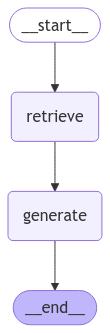

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
sequence_graph_builder = StateGraph(AgentState).add_sequence([retrieve, generate])

In [31]:
sequence_graph_builder.add_edge(START, 'retrieve')
sequence_graph_builder.add_edge('generate', END)

In [32]:
sequence_graph = sequence_graph_builder.compile()

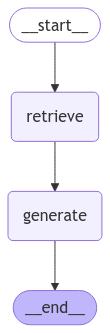

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
initial_state = {'query': query}
sequence_graph.invoke(initial_state)

AttributeError: 'list' object has no attribute 'items'